In [1]:
import numpy as np
import torch
from torchvision import models
from matplotlib import pyplot as plt
from integrated_gradients_pt import *

Load vgg16 model

In [2]:
vgg16 = models.vgg16(pretrained=True)

Load an example image. This image has already been preprocessed for predictions with vgg16.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


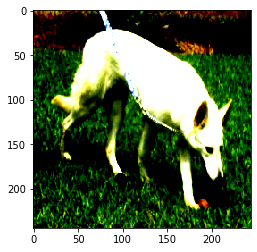

In [3]:
img = np.load('example_image.npy')
image = torch.tensor(img)
plt.imshow(img)

Next, we will calculate integrated gradients for the predicted class. If the kernel crashes, try reducing the number of steps or setting 'use_batches' to True and specifying a batch_size.

In [4]:
X = torch.tensor(image.numpy()).unsqueeze(0).permute(0,3,1,2)
with torch.no_grad():
    res = vgg16(X)
index = res.argmax()
baseline = torch.zeros_like(X[0]).unsqueeze(0) + X.min()
ig = integrated_gradients(model=vgg16, model_kwargs={}, unpack=True, index=index, X=X, baseline=baseline, steps=50, use_batches=False, batch_size=3)

And let's visualize the results:

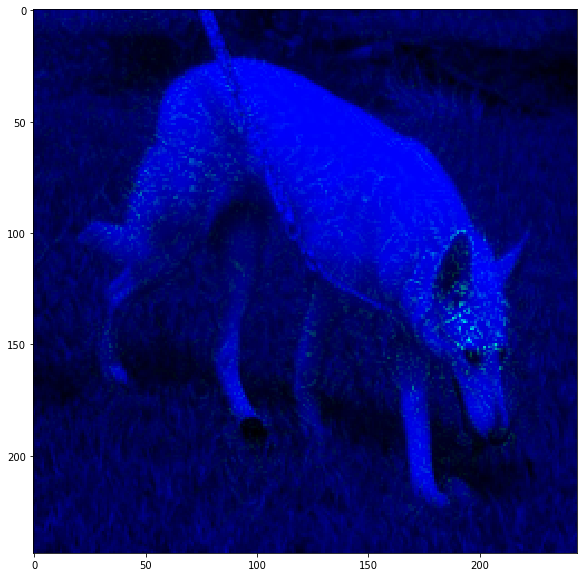

In [5]:
fig = plt.figure(figsize=(10,10))
orig = np.zeros_like(image.numpy())
orig[:,:,2] = np.mean(image.numpy(), axis=2)
orig[:,:,2] -= np.min(orig)
orig[:,:,2] /= np.max(orig)

flat_igs = ig[0].squeeze(0).permute(1,2,0).mean(2).numpy().copy()
pos = np.where(flat_igs>0)

orig[pos[0],pos[1],1] = flat_igs[pos]
orig[:,:,1] /= np.max(orig[:,:,1])

_ = plt.imshow(orig)

That's not bad--we can clearly tell that the most important pixels are located around the dog's head and right ear. Those are reasonable places to be looking at for animal predictions. Our model seems to be working as expected. 

In [6]:
raw = ig[0].squeeze(0).permute(1,2,0).numpy()
raw[np.where(raw<0)] = 0
raw /= np.max(raw)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


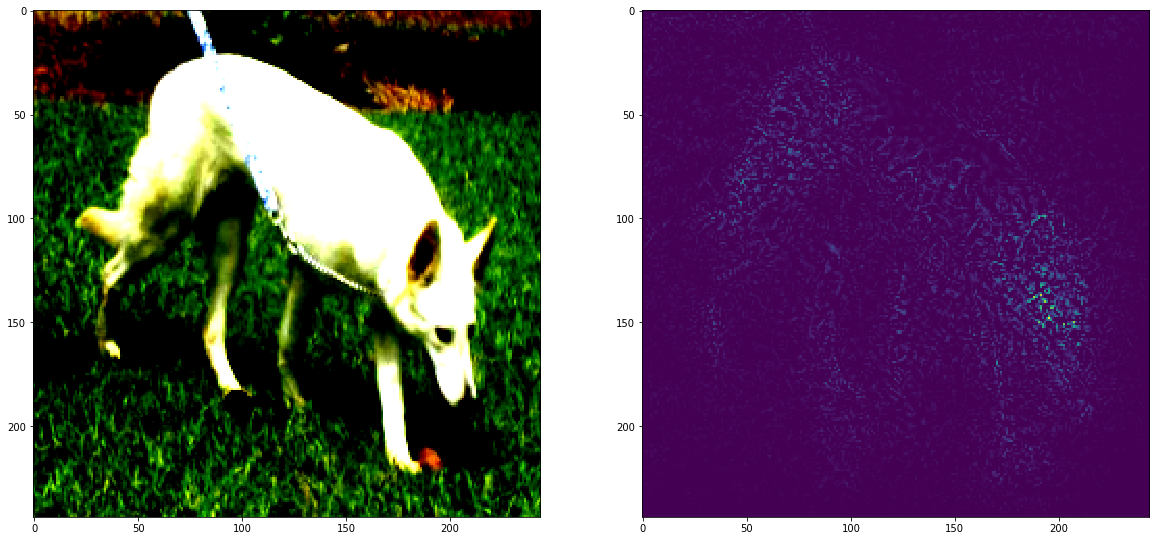

In [7]:
mean_raw = np.mean(raw, axis=2)
fig, axs = plt.subplots(1,2, figsize=(20, 10))
fig.suptitle('')
axs[0].imshow(image.numpy())
axs[1].imshow(mean_raw)

Again, you can clearly see important pixels are generally found on or near the dog. Though the head is most important, you can clearly see all four legs, the body, and part of the tail in the saliency map.

And below are the per-channel attributions:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


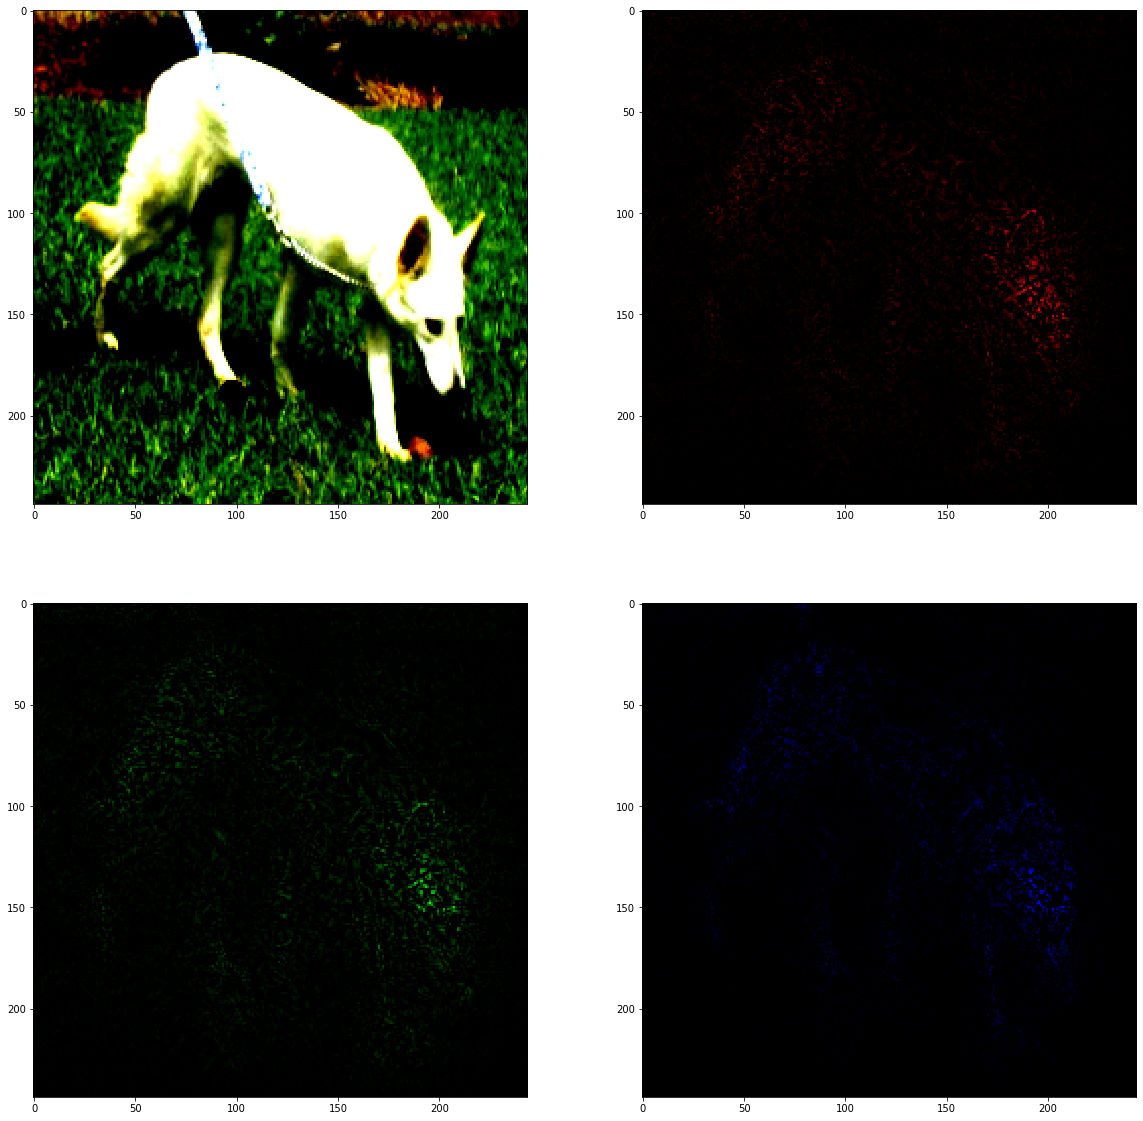

In [8]:
fig, axs = plt.subplots(2,2, figsize=(20, 20))
fig.suptitle('')
axs[0,0].imshow(image.numpy())
red = np.zeros_like(raw)
red[:, :, 0] = raw[:,:,0]
red /= np.max(red)
axs[0,1].imshow(red)
green = np.zeros_like(raw)
green[:, :, 1] = raw[:,:,1]
green /= np.max(green)
axs[1,0].imshow(green)
blue = np.zeros_like(raw)
blue[:, :, 2] = raw[:,:,2]
blue /= np.max(blue)
axs[1,1].imshow(blue)